#Import Library

In [ ]:
import sklearn.metrics as sm
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from sklearn.compose import ColumnTransformer
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras

#Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Bali 2015 - 2022.csv to Bali 2015 - 2022.csv


In [ ]:
data = pd.read_csv("Bali 2015 - 2022.csv")
data

,datetime,total_visitor,total_accomodation
0,1/1/2014,279257,16495
1,2/1/2014,275795,17221
2,3/1/2014,276573,17330
3,4/1/2014,280096,17737
4,5/1/2014,286033,18836
...,...,...,...
103,8/1/2022,276659,55932
104,9/1/2022,291162,56233
105,10/1/2022,305244,56611
106,11/1/2022,287398,56946


#Processing Data

In [ ]:
# datetime to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])
train_datetime = data['datetime']
data = data.set_index(['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   total_visitor       108 non-null    int64
 1   total_accomodation  108 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB


In [ ]:
data.isna().sum()

total_visitor         0
total_accomodation    0
dtype: int64

In [ ]:
#Reindex
data = data[['total_accomodation', 'total_visitor']]
data

,total_accomodation,total_visitor
datetime,,
2014-01-01,16495,279257
2014-02-01,17221,275795
2014-03-01,17330,276573
2014-04-01,17737,280096
2014-05-01,18836,286033
...,...,...
2022-08-01,55932,276659
2022-09-01,56233,291162
2022-10-01,56611,305244


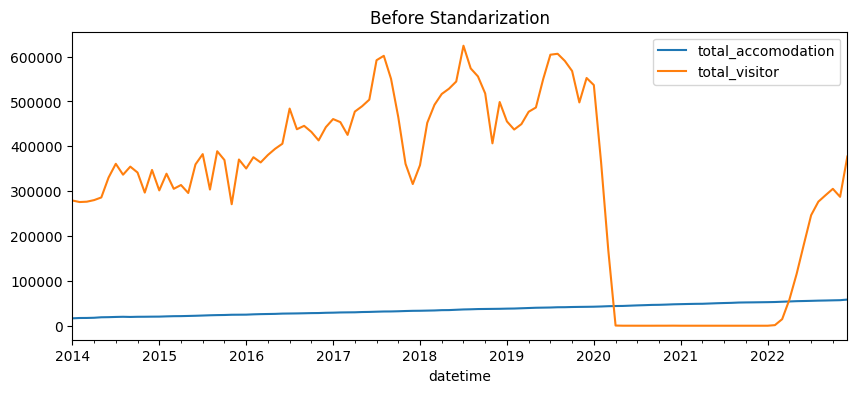

In [ ]:
data.plot(figsize=(10,4),legend=True)
plt.title('Before Standarization')
plt.show()

In [ ]:
# standarisasi
features = ['total_accomodation', 'total_visitor']
ct = ColumnTransformer([
    ('Std', StandardScaler(), features)
    ], remainder='passthrough')
data[features] = ct.fit_transform(data[features])

In [ ]:
data.head()

,total_accomodation,total_visitor
datetime,,
2014-01-01,-1.657855,-0.179053
2014-02-01,-1.596849,-0.196646
2014-03-01,-1.587690,-0.192692
2014-04-01,-1.553490,-0.174789
2014-05-01,-1.461140,-0.144619


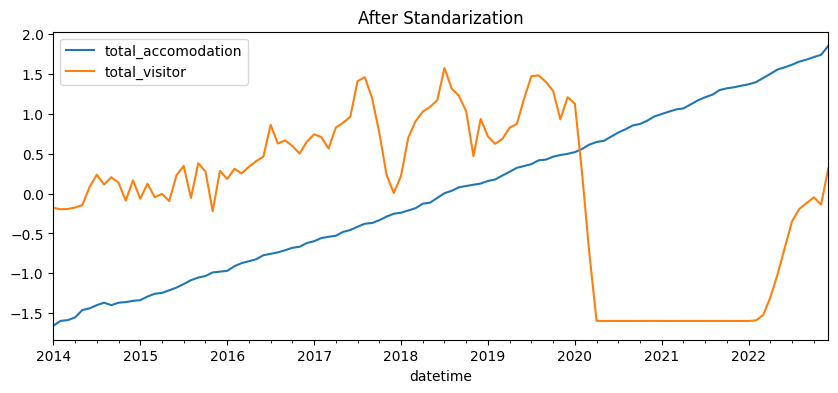

In [ ]:
data.plot(figsize=(10,4),legend=True)
plt.title('After Standarization')
plt.show()

In [ ]:
# Sliding Window
sequence_length = 10
d_tf = tf.keras.utils.timeseries_dataset_from_array(data.values, targets=data['total_visitor'][sequence_length:].values, sequence_length=sequence_length)
X = []
y = []
for X_batch, y_batch in d_tf:
    X.append(X_batch.numpy())
    y.append(y_batch.numpy())
X = np.array(X)
y = np.array(y)

#80:20

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.2, shuffle=False)

In [ ]:
print("Train X shape:", X_train.shape)
print("Train Y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", y_test.shape)

Train X shape: (78, 10, 2)
Train Y shape: (78,)
Test X shape: (20, 10, 2)
Test Y shape: (20,)


In [ ]:
#Model
model = Sequential()

# First LSTM layer
model.add(LSTM(units = 100, activation = 'tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))  # Assuming you want to predict 2 features (_tempm and _hum)

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100)               41200     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41301 (161.33 KB)
Trainable params: 41301 (161.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2,) #callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.5640 - val_loss: 2.0418
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2069 - val_loss: 2.5487
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1507 - val_loss: 2.6896
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1501 - val_loss: 2.3559
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1308 - val_loss: 2.3317
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1224 - val_loss: 2.3208
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1191 - val_loss: 2.2121
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1141 - val_loss: 2.2703
Epoch 9/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1094 - val_loss: 2.2649
Epoch 10/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1091 - val_loss: 2.2671
Epoch 11/50
8/8 [===============

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 388ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.693960034998149
MSE:  0.14138492229183472
MAPE:  1.119965744826929
MAE:  0.33839470385269865


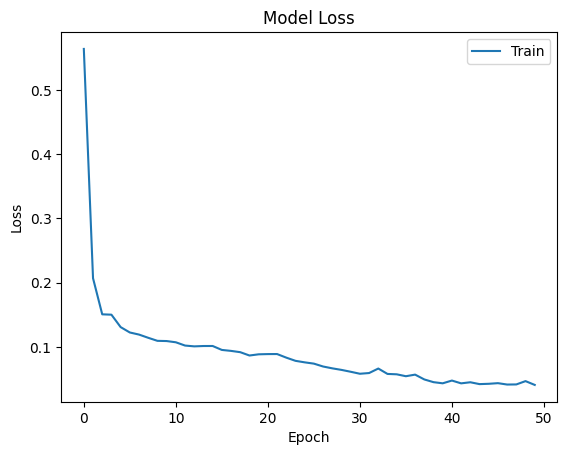

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

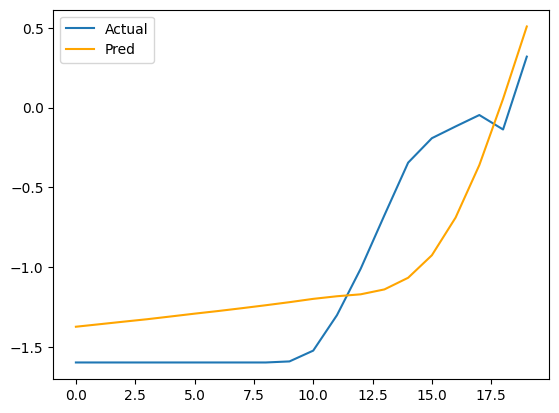

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][-1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, 2))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

# Get the last datetime from the df index
last_date = data.index[-1]

# Define the time step based on daily data
time_step = relativedelta(months=1)

# Create a list of datetime objects starting from the last df date
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]

# Convert the list to a datetime index
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
LSTM8020= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
LSTM8020['Time'] = pd.to_datetime(LSTM8020['Time'])
LSTM8020= LSTM8020.set_index(['Time'])

1/1 [==============================] - 0s 18ms/step


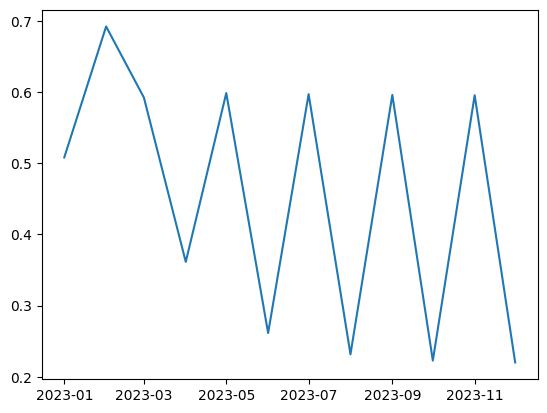

In [ ]:
plt.plot(LSTM8020)

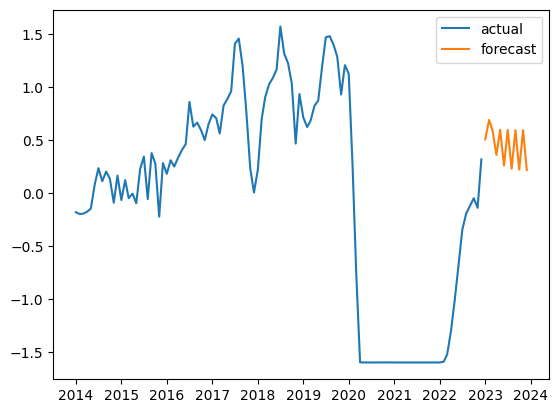

In [ ]:
plt.plot(data[['total_visitor']], label='actual')
plt.plot(LSTM8020['Predicted Value'], label='forecast')
plt.legend()

#70:30

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.3, shuffle=False)

In [ ]:
print("Train X shape:", X_train.shape)
print("Train Y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", y_test.shape)

Train X shape: (69, 9, 2)
Train Y shape: (69,)
Test X shape: (30, 9, 2)
Test Y shape: (30,)


In [ ]:
#Model
model = Sequential()

# First LSTM layer
model.add(LSTM(units = 128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))


# Output layer
model.add(Dense(units = 1))  # Assuming you want to predict 2 features (_tempm and _hum)

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
4/4 [==============================] - 4s 175ms/step - loss: 0.2997 - val_loss: 1.2052
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.1587 - val_loss: 1.3118
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.1478 - val_loss: 1.5353
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1260 - val_loss: 1.4569
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1244 - val_loss: 1.3243
Epoch 6/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1172 - val_loss: 1.2543
Epoch 7/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1135 - val_loss: 1.2215
Epoch 8/50
4/4 [==============================] - 0s 16ms/step - loss: 0.1097 - val_loss: 1.2006
Epoch 9/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1069 - val_loss: 1.1862
Epoch 10/50
4/4 [==============================] - 0s 16ms/step - loss: 0.1052 - val_loss: 1.2050
Epoch 11/50
4/4 [===========

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 414ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.08109478254976432
MSE:  0.34423988173888576
MAPE:  0.9720174288767728
MAE:  0.44806335280444015


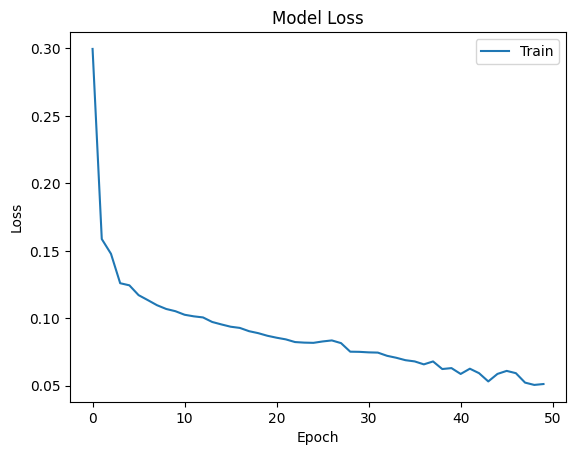

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

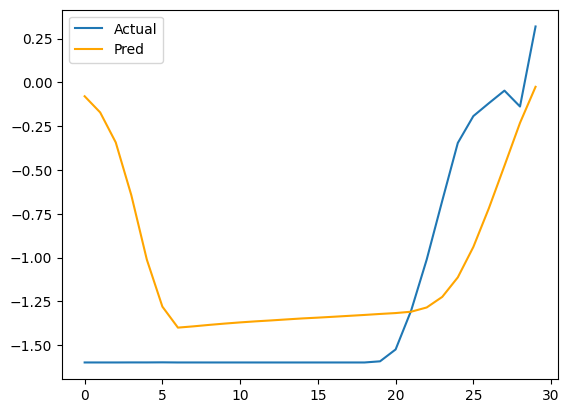

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, 2))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

# Get the last datetime from the df index
last_date = data.index[-1]

# Define the time step based on daily data
time_step = relativedelta(months=1)

# Create a list of datetime objects starting from the last df date
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]

# Convert the list to a datetime index
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
LSTM7030= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
LSTM7030['Time'] = pd.to_datetime(LSTM7030['Time'])
LSTM7030= LSTM7030.set_index(['Time'])

1/1 [==============================] - 0s 18ms/step


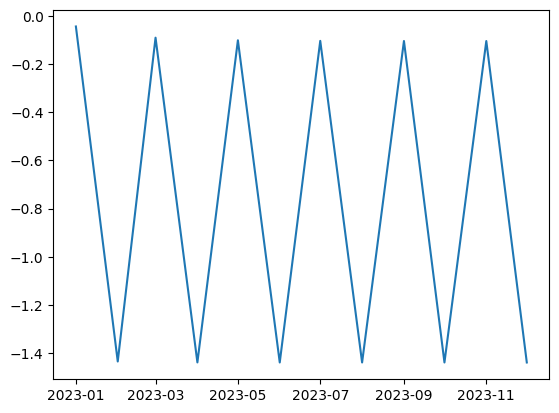

In [ ]:
plt.plot(LSTM7030)

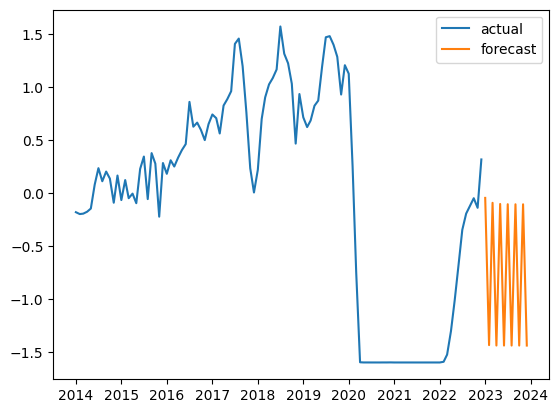

In [ ]:
plt.plot(data[['total_visitor']], label='actual')
plt.plot(LSTM7030['Predicted Value'], label='forecast')
plt.legend()

#60 : 40

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.4, shuffle=False)

In [ ]:
print("Train X shape:", X_train.shape)
print("Train Y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", y_test.shape)

Train X shape: (58, 10, 2)
Train Y shape: (58,)
Test X shape: (40, 10, 2)
Test Y shape: (40,)


In [ ]:
#Model
model = Sequential()

# First LSTM layer
model.add(LSTM(units = 64,  return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))  # Assuming you want to predict 2 features (_tempm and _hum)

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                17152     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (67.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 3s 249ms/step - loss: 0.4531 - val_loss: 0.7273
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 0.3134 - val_loss: 0.5198
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 0.2330 - val_loss: 0.3431
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 0.1962 - val_loss: 0.2206
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 0.1700 - val_loss: 0.1694
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 0.1528 - val_loss: 0.1563
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.1284 - val_loss: 0.1581
Epoch 8/50
3/3 [==============================] - 0s 19ms/step - loss: 0.1158 - val_loss: 0.1580
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.1194 - val_loss: 0.1616
Epoch 10/50
3/3 [==============================] - 0s 19ms/step - loss: 0.1216 - val_loss: 0.1714
Epoch 11/50
3/3 [===========

In [ ]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [ ]:
print('R2 =', r2_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2 = 0.14592183039320528
MSE:  0.8409538402658667
MAPE:  1.073018583265981
MAE:  0.723300111516987


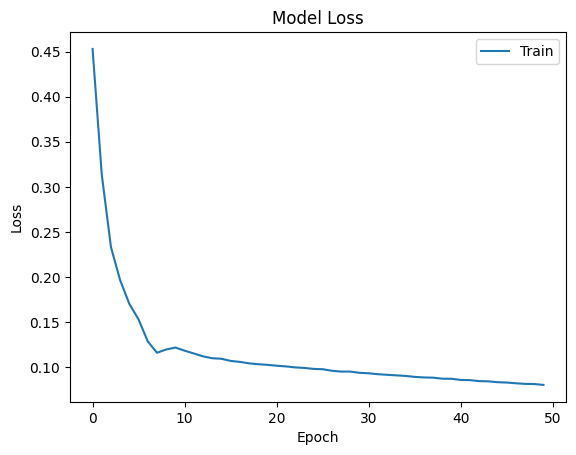

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

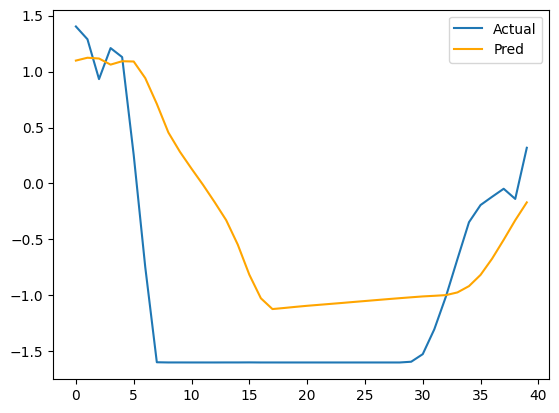

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, color='orange', label='Pred')
plt.legend()

In [ ]:
# Forecasts
last_sequence = X[0][1]
forecasts = []
forecasts_period = 12

for _ in range(forecasts_period):
    input_sequence = last_sequence.reshape((1, sequence_length, 2))
    forecast = model.predict(input_sequence)
    forecasts.append(forecast[0, 0])

    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[-1, 0] = forecast[0, 0]

from datetime import datetime, timedelta

# Get the last datetime from the df index
last_date = data.index[-1]

# Define the time step based on daily data
time_step = relativedelta(months=1)

# Create a list of datetime objects starting from the last df date
datetimes = [last_date + i * time_step for i in range(1, forecasts_period + 1)]

# Convert the list to a datetime index
time_axis = pd.DatetimeIndex(datetimes)

# Create the DataFrame with datetime index
LSTM6040= pd.DataFrame({'Time': time_axis, 'Predicted Value': forecasts})
LSTM6040['Time'] = pd.to_datetime(LSTM6040['Time'])
LSTM6040= LSTM6040.set_index(['Time'])

1/1 [==============================] - 0s 28ms/step


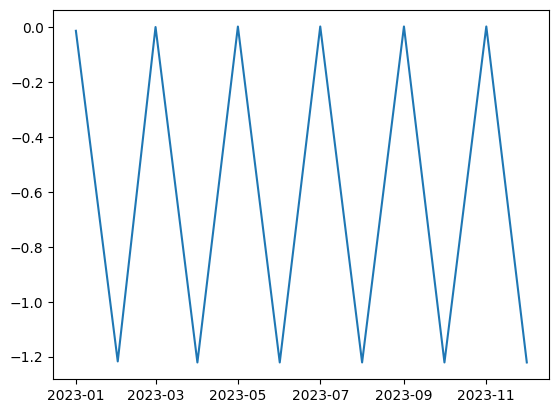

In [ ]:
plt.plot(LSTM6040)

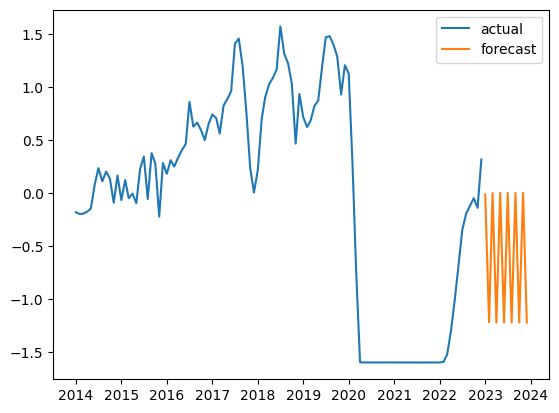

In [ ]:
plt.plot(data[['total_visitor']], label='actual')
plt.plot(LSTM6040['Predicted Value'], label='forecast')
plt.legend()